# Explainable AI

## Setup

In [1]:
import os
import glob
from math import ceil
from collections import defaultdict


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

import shap
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split

In [2]:
shap.explainers._deep.deep_tf.op_handlers['FusedBatchNormV3'] = shap.explainers._deep.deep_tf.passthrough
shap.explainers._deep.deep_tf.op_handlers['AddV2'] = shap.explainers._deep.deep_tf.passthrough

In [3]:
rng = np.random.default_rng(seed=42)

## Emotion

### Load and Prepare Model and Data

In [4]:
emotion_classifier = load_model(os.path.join(os.path.dirname('__file__'), '../models/emotion_classifier.h5'))

In [5]:
data_emotion = pd.read_csv(os.path.join(os.path.dirname('__file__'), '../../data/emotion/fer2013.csv'))
labels_emotion = pd.read_csv(os.path.join(os.path.dirname('__file__'), '../../data/emotion/fer2013new.csv'))


n_samples = len(data_emotion)
width = 48
height = 48


orig_class_names = ['neutral', 'happiness', 'surprise', 'sadness', 'anger', 
                    'disgust', 'fear', 'contempt', 'unknown', 'NF']

y_e = np.array(labels_emotion[orig_class_names])
X_e = np.zeros((n_samples, width, height, 1))
for i in range(n_samples):
    X_e[i] = np.fromstring(data_emotion['pixels'][i], dtype=int, sep=' ').reshape((height, width, 1))

# Using mask to remove unknown or NF images
y_mask = y_e.argmax(axis=-1)
mask = y_mask < orig_class_names.index('unknown')
X_e = X_e[mask]
y_e = y_e[mask]

# Convert to probabilities between 0 and 1
y_e = y_e[:, :-2] * 0.1

# Add contempt to neutral and remove it
y_e[:, 0] += y_e[:, 7]
y_e = y_e[:, :7]

test_size_e = ceil(len(X_e) * 0.1)

# Split Data
x_train_e, x_test_e, y_train_e, y_test_e = train_test_split(X_e, 
                                                            y_e, 
                                                            test_size=test_size_e, 
                                                            random_state=14)

### Initialize Shap

In [6]:
background_e = x_train_e[rng.choice(x_train_e.shape[0], 500, replace=False)]

In [7]:
emotion_explainer = shap.DeepExplainer(emotion_classifier, background_e)

keras is no longer supported, please use tf.keras instead.
Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.


### Visualize Emotion Model

`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


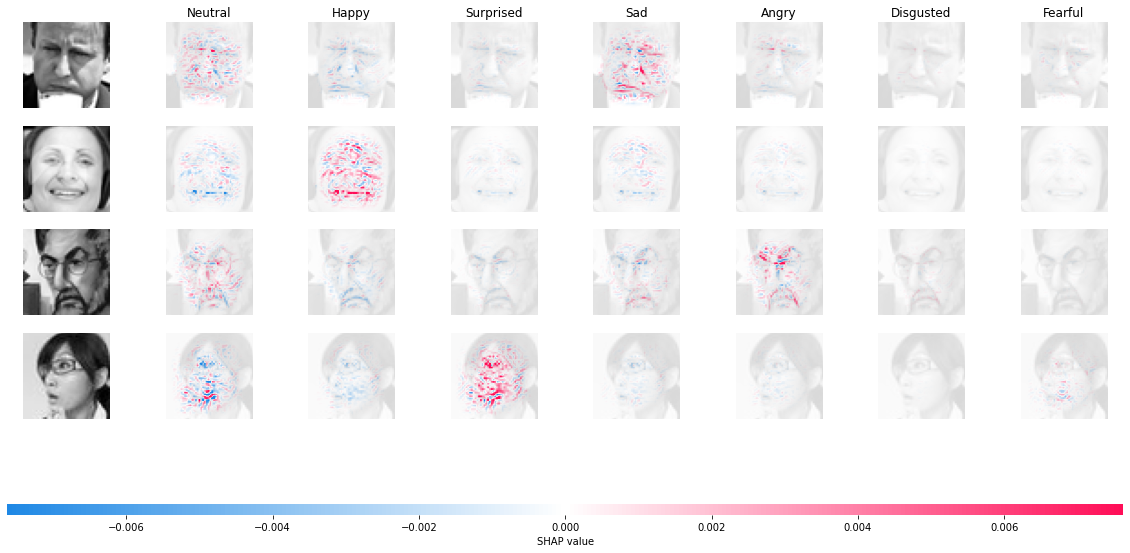

In [8]:
emotion_values = emotion_explainer.shap_values(x_test_e[:4])

index_names_emotion = np.array([['Neutral', 'Happy', 'Surprised', 'Sad', 'Angry', 'Disgusted', 'Fearful']])
for i in range(3):
    index_names_emotion = np.append(index_names_emotion, np.array([['', '', '', '', '', '', '']]), axis=0)

shap.image_plot(emotion_values, x_test_e[:4], index_names_emotion)

## Age

### Load and Prepare Model and Data

In [9]:
age_classifier = load_model(os.path.join(os.path.dirname('__file__'), '../models/age_classifier.h5'))

In [10]:
def load_image(filename: str, size: tuple[int, int]) -> np.array:
    """Loads and resizes the image."""
    image = Image.open(filename).convert('L')
    resized_image = image.resize(size)
    return np.array(resized_image)

In [11]:
images = defaultdict()

path = '../../data/face_age'

for subfolder in os.listdir(path):
    images_per_folder = glob.glob(f'{path}/{subfolder}/*.png')
    number_of_images = len(images_per_folder)
    key = int(subfolder.lstrip('0'))
    tmp = []

    for filename in images_per_folder:
        image = load_image(filename, size=(width, height))
        tmp.append(image)

    images[key] = tmp
    tmp = []

child = []
young_adult = []
adult = []
senior = []

for key, value in images.items():
    if key <= 16:
        child += value
    elif 16 < key <= 30:
        young_adult += value
    elif 30 < key <= 60:
        adult += value
    else:
        senior += value

data_age = defaultdict()
data_age['child'] = child
data_age['young_adult'] = young_adult
data_age['adult'] = adult
data_age['senior'] = senior

In [12]:
X_a = np.array([])
y_a = np.array([])
labels_age = {
    'child': 0,
    'young_adult': 1,
    'adult': 2,
    'senior': 3,
}

for key, value in data_age.items():
    n = len(value)
    X_a = np.append(X_a, value)
    y_a = np.append(y_a, [labels_age[key]] * n)

X_a = X_a.reshape(-1, width, height, 1)

test_size_a = ceil(len(X_a) * 0.1)

# Split Data
x_train_a, x_test_a, y_train_a, y_test_a = train_test_split(X_a, 
                                                            y_a, 
                                                            test_size=test_size_a, 
                                                            random_state=42)

### Initialize Shap

In [13]:
background_a = x_train_a[rng.choice(x_train_a.shape[0], 500, replace=False)]

In [14]:
age_explainer = shap.DeepExplainer(age_classifier, background_a)

### Visualize Age Model

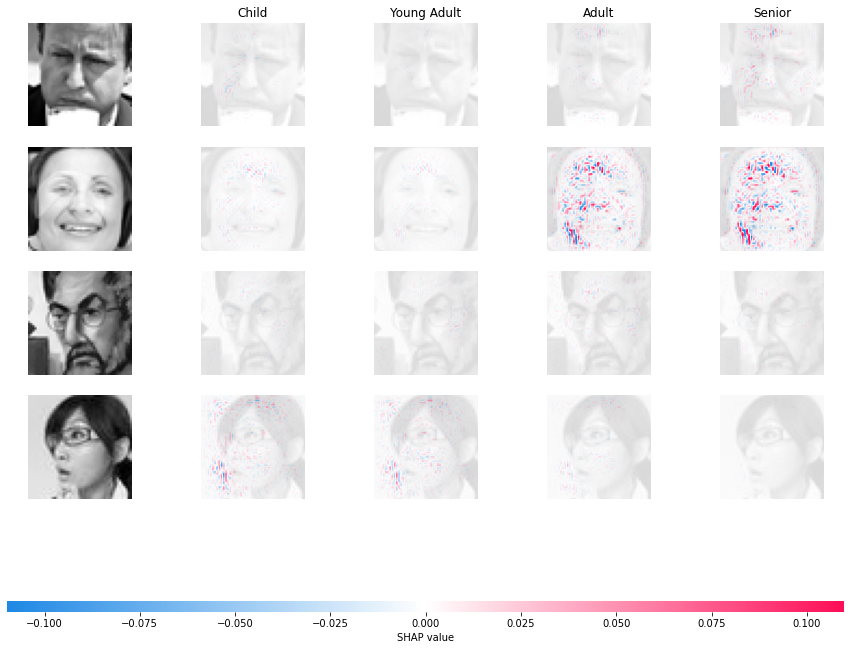

In [15]:
age_values = age_explainer.shap_values(x_test_e[:4])

index_names_age = np.array([['Child', 'Young Adult', 'Adult', 'Senior']])
for i in range(3):
    index_names_age = np.append(index_names_age, np.array([['', '', '', '']]), axis=0)

shap.image_plot(age_values, x_test_e[:4], index_names_age)